In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

# Week6 VAE Programming Exercise

## 1) Train a VAE model on the MNIST dataset with a 2 dimensional latent space. Plot the encoded samples in the latent space and color-code the different digit classes (see the PPCA tasks for comparison). Does this model model separate the classes better than the PPCA model, we have previously investigated?

### Define hyperparams

In [2]:
batch_size = 128
log_interval = 10
epochs = 4 # 10
torch.manual_seed(1)

use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

### Load train and test data

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

### Define model

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # Latent space of 2D
        self.fc22 = nn.Linear(100, 2) # Latent space of 2D
        self.fc3 = nn.Linear(2, 100) # Latent space of 2D
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x): # when we call model(data), it is the same as model.forward(data)
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
        
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [5]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

### Train & test

In [6]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.322083
Train Epoch: 1 [1280/60000 (2%)]	Loss: 325.888763
Train Epoch: 1 [2560/60000 (4%)]	Loss: 230.578018
Train Epoch: 1 [3840/60000 (6%)]	Loss: 214.113647
Train Epoch: 1 [5120/60000 (9%)]	Loss: 210.053818
Train Epoch: 1 [6400/60000 (11%)]	Loss: 203.988800
Train Epoch: 1 [7680/60000 (13%)]	Loss: 201.175262
Train Epoch: 1 [8960/60000 (15%)]	Loss: 199.034683
Train Epoch: 1 [10240/60000 (17%)]	Loss: 188.862839
Train Epoch: 1 [11520/60000 (19%)]	Loss: 193.630615
Train Epoch: 1 [12800/60000 (21%)]	Loss: 188.461151
Train Epoch: 1 [14080/60000 (23%)]	Loss: 198.145691
Train Epoch: 1 [15360/60000 (26%)]	Loss: 191.590332
Train Epoch: 1 [16640/60000 (28%)]	Loss: 190.048325
Train Epoch: 1 [17920/60000 (30%)]	Loss: 189.860031
Train Epoch: 1 [19200/60000 (32%)]	Loss: 190.038177
Train Epoch: 1 [20480/60000 (34%)]	Loss: 187.516495
Train Epoch: 1 [21760/60000 (36%)]	Loss: 181.459900
Train Epoch: 1 [23040/60000 (38%)]	Loss: 179.565903
Train Epoch: 1 [24320/60000 

### Plot

In [7]:
test_data = list(test_loader)
test_sample_num = len(test_data)
results = []
groups = torch.empty(0)
j = 0
for i in range(test_sample_num):
    labels = test_data[i][1]
    groups = torch.cat((groups, labels))
    
    images = test_data[i][0]
    K = images.shape[0]
    for k in range(K):
        img = images[k,:,:,:]
        img = torch.flatten(img)
        mean_img = model.encode(img)[0] # X,Y
        results.append(mean_img.detach().numpy())
        j +=1

results = np.array(results)

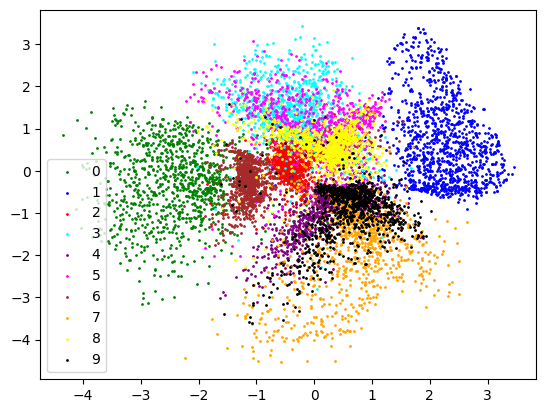

In [8]:
scatter_x = results[:,0]
scatter_y = results[:,1]
colors = ['green', 'blue', 'red', 'cyan', 'purple', 'magenta', 'brown', 'orange', 'yellow', 'black']

fig, ax = plt.subplots()
for g in np.unique(groups):
    g = int(g)
    idx = np.where(groups == g)
    ax.scatter(scatter_x[idx], scatter_y[idx], c=colors[g], label=g, s=1)
    
ax.legend()
plt.savefig('e3-vae_1.png')
plt.show()

## 2) We continue the latent space investigation by evaluating possible outcomes of p(z). As a means to do that, we revisit the inverse Gassian CDF and uniformly distributed samples and its map to a random Normal distribution.: Create a 2D grid of size (k,k) (e.g. torch.linspace, torch.meshgrid) and map through torch.distributions.normal.Normal.icdf to get equally spaced points according to the Gaussian CDF. Create a k,k figure for each entry and plot an image of p(x|z).

/Users/daniel/.miniconda/envs/pyro/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


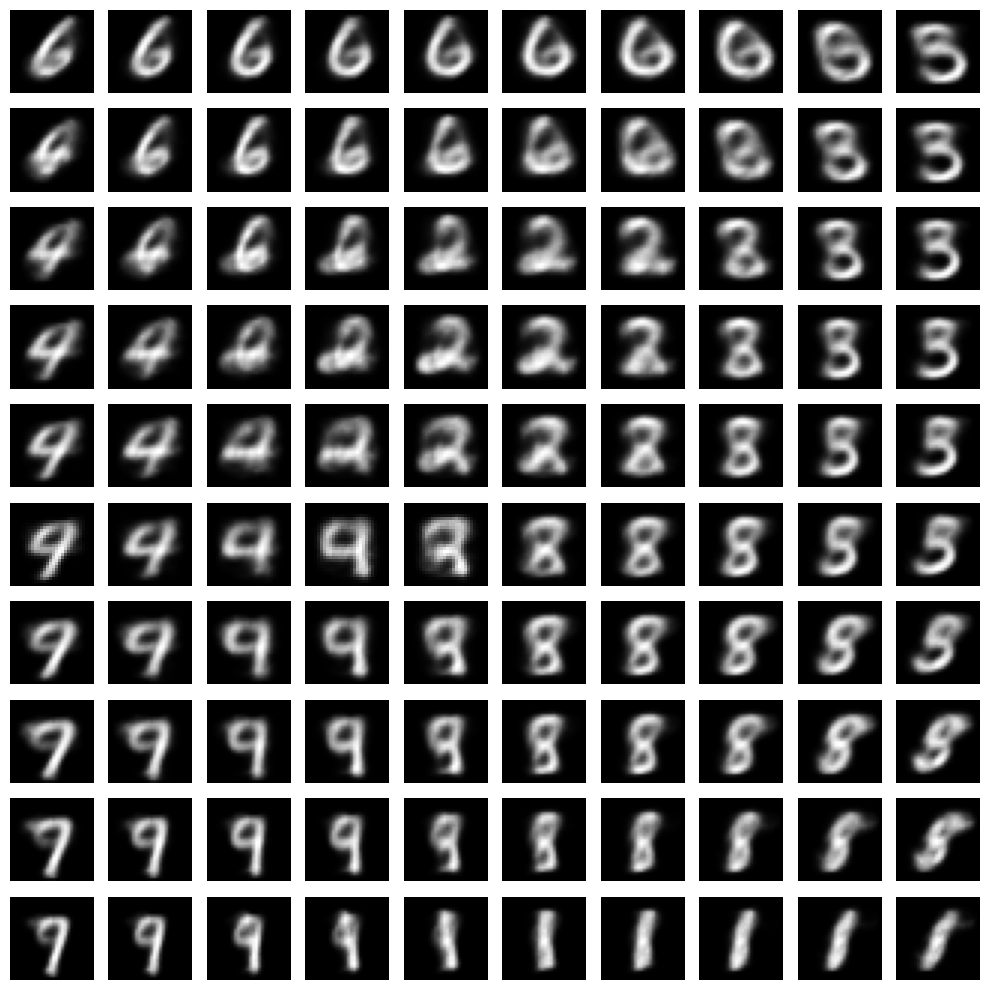

In [10]:
M = 10
x = torch.linspace(start=0, end=1, steps=M+2)[:-1][1:]
mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc = 0, scale = 1)
gauss_x = gauss.icdf(mesh_x)
gauss_y = gauss.icdf(mesh_y)

fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(10, 10))
for i in range(M):
    for j in range(M):
        _x = gauss_x[i,j].item()
        _y = gauss_y[i,j].item()
        im = model.decode(torch.Tensor([_x, _y]))
        im = im.detach().numpy().reshape((28, 28))
        
        ax[i,j].imshow(im, cmap='gray')
        ax[i,j].axis('off')

plt.tight_layout()
plt.savefig('e3_vae_2.png')
plt.show()